# Import Libraries

In [ ]:
import pandas as pd 
import numpy as np
from scipy.stats import beta
from datetime import datetime
import logging
import requests
from io import StringIO
import io
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter


# Global Configuration

In [68]:
# Back-test date range
BACKTEST_START     = '2011-06-01' 
BACKTEST_END       = '2025-06-01' 

# Rolling window length (in months)
INVESTMENT_WINDOW  = 12

# Step frequency for window start-dates: 'Daily', 'Weekly' or 'Monthly'
PURCHASE_FREQ      = 'Daily'

# Minimum per-period weight (to avoid zero allocations)
MIN_WEIGHT         = 1e-5

PURCHASE_FREQ_TO_OFFSET = {
    'Daily':   '1D',
    'Weekly':  '7D',
    'Monthly': '1M',
}

In [69]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Download BTC Data

In [70]:
try:
    from coinmetrics.api_client import CoinMetricsClient
except ImportError:
    raise ImportError("coinmetrics.api_client module is required. Install it via pip:\n\n    pip install coinmetrics-api-client")

def extract_btc_data_to_csv(local_path='data/btc_data.csv'):
    # Coin Metrics BTC CSV (raw GitHub URL)
    url = "https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv"
    
    # Download the content
    response = requests.get(url)
    response.raise_for_status()  # raises an error for bad responses
    
    # Parse CSV content
    btc_df = pd.read_csv(StringIO(response.text))

    btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
    btc_df['time'] = btc_df['time'].dt.tz_localize(None)
    btc_df.set_index('time', inplace=True)

    btc_df.to_csv(local_path)
    
    # Show the df
    btc_df

# Load BTC Data

In [71]:
def load_data():
    df = pd.read_csv("data/btc_data.csv", index_col=0, parse_dates=True)
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    return df

def validate_price_data(df):
    if df.empty or 'PriceUSD' not in df.columns:
        raise ValueError("Invalid BTC price data.")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be datetime.")

# DCA Strategy

## Hyper Parameters

In [72]:
_FULL_FEATURES = None

MIN_W = 1e-5
WINS = [30, 90, 180, 365, 1461]
FEATS = [f"z{w}" for w in WINS]
PROTOS = [(0.5, 5.0), (1.0, 1.0), (5.0, 0.5)]

# Optimized theta parameters from the final model run
THETA = np.array([
    1.3507, 1.073, -1.226, 2.5141, 2.9946, -0.4083, -0.1082, -0.6809,
    0.3465, -0.6804, -2.9974, -2.9991, -1.2658, -0.368, 0.7567, -1.9627,
    -1.9124, 2.9983, 0.5704, 0.0, 0.8669, 1.2546, 5.0
])

## Helper Functions

In [73]:
def softmax(x: np.ndarray) -> np.ndarray:
    """Converts a vector of scores into a probability distribution."""
    ex = np.exp(x - x.max())
    return ex / ex.sum()

def allocate_sequential(raw: np.ndarray) -> np.ndarray:
    """Strict left-to-right 'drain' allocator."""
    n = len(raw)
    floor = n * MIN_W
    rem_budget, rem_raw = 1 - floor, raw.sum()
    w = np.empty_like(raw)
    for i, x in enumerate(raw):
        share = 0 if rem_raw == 0 else (x / rem_raw) * rem_budget
        w[i] = MIN_W + share
        rem_budget -= share
        rem_raw -= x
    return w / w.sum()

def beta_mix_pdf(n: int, mix: np.ndarray) -> np.ndarray:
    """Generates a smooth baseline curve from a mixture of Beta distributions."""
    t = np.linspace(0.5 / n, 1 - 0.5 / n, n)
    return (mix[0] * beta.pdf(t, *PROTOS[0]) +
            mix[1] * beta.pdf(t, *PROTOS[1]) +
            mix[2] * beta.pdf(t, *PROTOS[2])) / n

def zscore(s: pd.Series, win: int) -> pd.Series:
    """Calculates the rolling z-score for a given series and window."""
    m = s.rolling(win, win // 2).mean()
    sd = s.rolling(win, win // 2).std()
    return ((s - m) / sd).fillna(0)

## Main DCA Strategy Functions

In [74]:
def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates features on the full historical data ONCE and returns the
    relevant slice. This robustly handles calls from different boilerplate
    functions and avoids boundary errors that cause leakage.
    """
    global _FULL_FEATURES

    # Only compute the full feature set if it hasn't been done yet.
    if _FULL_FEATURES is None:
        try:
            # Assumes 'btc_data.csv' is in the same directory.
            full_price_df = pd.read_csv("data/btc_data.csv", index_col=0, parse_dates=True)
        except FileNotFoundError:
            raise FileNotFoundError("data/btc_data.csv not found. Please ensure it's in the correct directory.")
        
        # Select only the PriceUSD column before doing anything else.
        full_price_df = full_price_df[['PriceUSD']]
        
        # We need history from before the backtest start date for rolling windows.
        full_price_df = full_price_df.loc["2010-07-18":]
        # full_price_df = full_price_df.loc["2010-07-18":] 

        log_prices = np.log(full_price_df['PriceUSD'])
        
        z_all = pd.DataFrame({f"z{w}": zscore(log_prices, w).clip(-4, 4) for w in WINS}, index=log_prices.index)
        
        # The strategy uses lagged features to avoid look-ahead bias.
        z_lag = z_all.shift(1).fillna(0)
        
        _FULL_FEATURES = full_price_df.join(z_lag)

    # Return the portion of the pre-computed features that matches the input index.
    return _FULL_FEATURES.reindex(df.index).fillna(0)


def compute_weights(df_window: pd.DataFrame) -> pd.Series:
    """
    Given a slice of data, computes portfolio weights that sum to 1.
    This function first calls construct_features to ensure the necessary
    feature columns are present.
    """
    if df_window.empty:
        return pd.Series(dtype=float)

    feat_slice = construct_features(df_window)

    alpha, beta_v = THETA[:18].reshape(3, 6), THETA[18:]
    
    # Use features from the first day to set the annual strategy
    first_day_feats = feat_slice[FEATS].iloc[0].values
    mix = softmax(alpha @ np.r_[1, first_day_feats])
    
    # Calculate the components of the allocation formula
    n_days = len(feat_slice)
    base_alloc = beta_mix_pdf(n_days, mix)
    dynamic_signal = np.exp(-(feat_slice[FEATS].values @ beta_v))
    
    # Combine signals and compute final weights
    raw_weights = base_alloc * dynamic_signal
    final_weights = allocate_sequential(raw_weights)
    
    return pd.Series(final_weights, index=feat_slice.index)

# Run DCA Strategy

In [75]:
def _make_window_label(window_start: pd.Timestamp, window_end: pd.Timestamp) -> str:
    """
    Format "YYYY-MM-DD → YYYY-MM-DD" for a rolling window.
    """
    start_str = pd.to_datetime(window_start).strftime("%Y-%m-%d")
    end_str   = pd.to_datetime(window_end).strftime("%Y-%m-%d")
    return f"{start_str} → {end_str}"

In [76]:
def compute_cycle_spd(
    dataframe: pd.DataFrame,
    strategy_function
) -> pd.DataFrame:
    """
    Compute sats‐per‐dollar (SPD) stats over rolling windows.

    - Uses full‐history features (no look‐ahead).
    - Window length = INVESTMENT_WINDOW months.
    - Step every PURCHASE_FREQ.
    - Returns a DataFrame indexed by window label, with:
        min_sats_per_dollar, max_sats_per_dollar,
        uniform_sats_per_dollar, dynamic_sats_per_dollar,
        uniform_percentile, dynamic_percentile, excess_percentile.
    """
    # 1) Precompute full-history features & restrict to backtest
    full_feat = construct_features(dataframe).loc[BACKTEST_START:BACKTEST_END]

    # 2) Window parameters
    window_offset  = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq      = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]

    results = []
    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end  = window_start + window_offset
        feat_slice  = full_feat.loc[window_start:window_end]
        price_slice = dataframe["PriceUSD"].loc[window_start:window_end]

        if price_slice.empty:
            continue

        label       = _make_window_label(window_start, window_end)
        inv_price   = (1.0 / price_slice) * 1e8  # sats per dollar

        # Compute weights on this slice
        weight_slice = strategy_function(feat_slice)

        # Uniform vs. dynamic SPD
        uniform_spd = inv_price.mean()
        dynamic_spd = (weight_slice * inv_price).sum()

        # Min/max for percentile scaling
        min_spd = inv_price.min()   # low price → high SPD
        max_spd = inv_price.max()   # high price → low SPD
        span    = max_spd - min_spd

        uniform_pct = (uniform_spd - min_spd) / span * 100
        dynamic_pct = (dynamic_spd - min_spd) / span * 100

        results.append({
            "window":                   label,
            "min_sats_per_dollar":      min_spd,
            "max_sats_per_dollar":      max_spd,
            "uniform_sats_per_dollar":  uniform_spd,
            "dynamic_sats_per_dollar":  dynamic_spd,
            "uniform_percentile":       uniform_pct,
            "dynamic_percentile":       dynamic_pct,
            "excess_percentile":        dynamic_pct - uniform_pct,
        })

    return pd.DataFrame(results).set_index("window")

# Other Data Processing

In [211]:
def extract_weight(
    dataframe: pd.DataFrame,
    strategy_function
) -> pd.DataFrame:
    # 1) Precompute full-history features & restrict to backtest
    full_feat = construct_features(dataframe).loc[BACKTEST_START:BACKTEST_END]

    # 2) Window parameters
    window_offset  = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]

    all_weights = []

    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=pd.DateOffset(months=INVESTMENT_WINDOW)
    ):
        window_end  = window_start + window_offset
        feat_slice  = full_feat.loc[window_start:window_end]

        # Compute weights on this slice
        weight_slice = strategy_function(feat_slice)

        all_weights.append(weight_slice)

    final_series = pd.concat(all_weights, ignore_index=False)

    final_series = final_series.reset_index()
    final_series.columns = ["date", "weight"]

    return final_series

In [214]:
def combine_weight_price(btc_df: pd.DataFrame) -> pd.DataFrame:
    """
    Combine extract_weight output with btc_df on date (btc_df index).
    Output columns: ["date", "weight", "PriceUSD"]
    """

    # 1. Get weights (date, weight)
    df_weight = extract_weight(btc_df, compute_weights)

    # Ensure datetime
    df_weight["date"] = pd.to_datetime(df_weight["date"])

    # 2. Prepare btc_df (date is in index)
    df_price = btc_df.copy()
    df_price.index = pd.to_datetime(df_price.index)

    # Move index to column called "date"
    df_price = df_price.reset_index().rename(columns={"time": "date"})

    # Keep only what we need
    df_price = df_price[["date", "PriceUSD"]]

    # 3. Merge on date
    df_combo = pd.merge(
        df_weight,
        df_price,
        on="date",
        how="inner"
    )

    # 4. Sort and reset index
    df_combo = df_combo.sort_values("date")
    df_combo = df_combo.drop_duplicates(subset="date", keep="last")
    df_combo = df_combo.reset_index(drop=True)

    df_combo = df_combo.set_index("date")

    return df_combo


In [243]:
def compute_spd_percentile(
    file_path: str = "data/weight_price_ma20.csv",
    output_path: str = "data/weight_price_ma20_spd_pct.csv"
):
    # Load data
    df = pd.read_csv(file_path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    # Define window year (June 1 – May 31)
    year = df["date"].dt.year
    month = df["date"].dt.month

    # June–December => current year, January–May => previous year
    df["window_year"] = np.where(month >= 6, year, year - 1)
    
    # spd = 1 / (BTC/USD) * 100,000,000 
    df["spd"] = (1 / df["PriceUSD"]) * 100_000_000

    # Get min / max price in each window year
    grp = df.groupby("window_year")["spd"]
    worst_spd = grp.transform("min")
    best_spd = grp.transform("max")

    # spd_pct = (your SPD - worst SPD) / (best SPD - worst SPD) * 100
    df["spd_percentile"] = (df["spd"] - worst_spd) / (best_spd - worst_spd) * 100

    # Drop rows where price_percentile is NaN
    df = df.dropna(subset=["spd_percentile"])

    # Round to integer
    df["spd_percentile"] = df["spd_percentile"].round().astype(int)

    # Save file
    df.to_csv(output_path, index=False)

    return df


In [249]:
def add_forward_returns(
    file_path: str = "data/weight_price_ma20_spd_pct.csv",
    output_path: str = "data/weight_price_ma20_spd_pct_return.csv"
):
    """
    Add forward returns (30d, 60d, 365d) based on PriceUSD.
    Return is calculated as: (future_price / current_price) - 1
    """

    # Load data
    df = pd.read_csv(file_path)

    # Ensure datetime and sorted
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    # Make sure price is numeric
    df["PriceUSD"] = pd.to_numeric(df["PriceUSD"], errors="coerce")

    # Add forward returns
    df["30d_return"]  = (df["PriceUSD"].shift(-30)  / df["PriceUSD"]) - 1
    df["60d_return"]  = (df["PriceUSD"].shift(-60)  / df["PriceUSD"]) - 1
    df["365d_return"] = (df["PriceUSD"].shift(-365) / df["PriceUSD"]) - 1

    # Drop rows where any of the return columns is NaN
    df = df.dropna(subset=["30d_return", "60d_return", "365d_return"])

    df.to_csv(output_path, index=False)

    return df


# Run main workflow

## Load BTC Data

In [ ]:
btc_df = load_data()
validate_price_data(btc_df)
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END]

## Load weight and price through each windows

In [ ]:
df_w_p = combine_weight_price(btc_df)
df_w_p.to_csv("data/weight_price.csv")

## Load MA20 through each windows

In [222]:
df_w_p["MA20"] = df_w_p["PriceUSD"].rolling(window=20).mean()
df_w_p.to_csv("data/weight_price_ma20.csv")

# Load percentile through each windows

In [245]:
df_w_p_spd_pct = compute_spd_percentile()

/var/folders/dr/_j6dcxqs3zn8h1179k47j1s80000gn/T/ipykernel_38483/1475057675.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["spd_percentile"] = df["spd_percentile"].round().astype(int)


## Load Return through each windows

In [253]:
df_w_p_spd_pct_r = add_forward_returns()

## Load Rolling-window SPD backtested Data

In [ ]:
df_spd = compute_cycle_spd(btc_df, compute_weights)
df_spd.to_csv("data/backtested_btc_data.csv")

In [127]:
df_spd.tail(5)

,min_sats_per_dollar,max_sats_per_dollar,uniform_sats_per_dollar,dynamic_sats_per_dollar,uniform_percentile,dynamic_percentile,excess_percentile
window,,,,,,,
2024-05-28 → 2025-05-28,897.045908,1857.39123,1300.336244,1759.101721,41.994304,89.765191,47.770887
2024-05-29 → 2025-05-29,897.045908,1857.39123,1298.922494,1758.942928,41.847091,89.748656,47.901565
2024-05-30 → 2025-05-30,897.045908,1857.39123,1297.507403,1758.803621,41.699739,89.734150,48.034411
2024-05-31 → 2025-05-31,897.045908,1857.39123,1296.120833,1758.766249,41.555357,89.730259,48.174902
2024-06-01 → 2025-06-01,897.045908,1857.39123,1294.649401,1758.600634,41.402138,89.713013,48.310875


## Load Allocation Animation

2025-11-21 12:04:08 INFO     Animation.save using <class 'matplotlib.animation.PillowWriter'>


KeyboardInterrupt: 

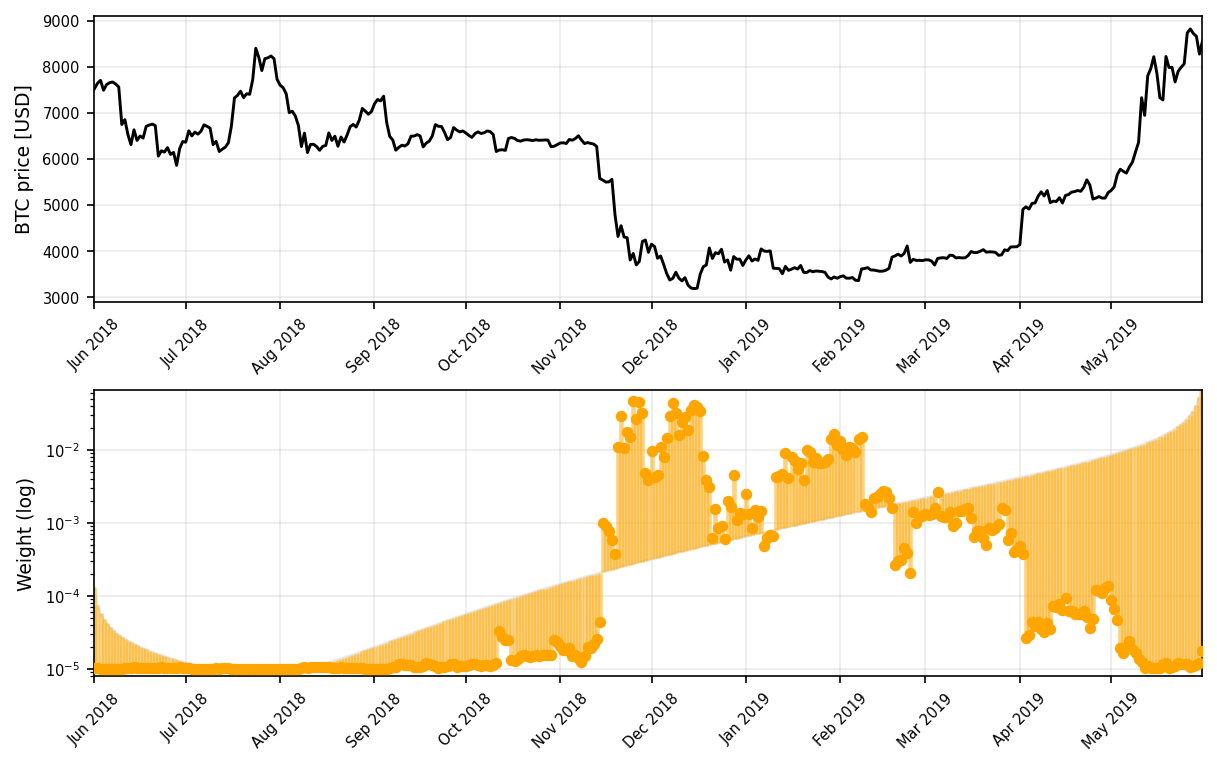

In [216]:
def zscore(s: pd.Series, win: int) -> pd.Series:
    m  = s.rolling(win, win // 2).mean()
    sd = s.rolling(win, win // 2).std()
    return ((s - m) / sd).fillna(0)


def fetch_btc() -> pd.Series:
    url, cache = ("https://raw.githubusercontent.com/coinmetrics/data/"
                  "master/csv/btc.csv", Path("btc.csv"))
    try:
        txt = requests.get(url, timeout=15).text
        cache.write_text(txt)
    except Exception:
        txt = cache.read_text()
    df = pd.read_csv(io.StringIO(txt), usecols=["time", "PriceUSD"])
    df["date"] = pd.to_datetime(df["time"]).dt.normalize()
    df.set_index("date", inplace=True)
    return df["PriceUSD"].loc["2010-07-18":].astype(float)


z_all = pd.DataFrame({f"z{w}": zscore(log_full, w).clip(-4, 4) for w in WINS})
z_lag = z_all.shift(1).fillna(0)

FEATS = z_lag.columns.tolist()
price_full = fetch_btc()
log_full   = np.log(price_full)
price      = price_full.loc[BACKTEST_START:BACKTEST_END]

BACKTEST_START = pd.Timestamp("2011-06-01")
BACKTEST_END   = pd.Timestamp("2025-06-01")

WINDOW_STARTS = pd.date_range(
    BACKTEST_START,
    BACKTEST_END - pd.Timedelta(364, "D"),
    freq="D"
)
WINDOW_N = len(WINDOW_STARTS)

def uniform_spd_pct(idx: pd.DatetimeIndex) -> float:
    w  = np.full(len(idx), 1 / len(idx))
    btc = (w / price.loc[idx].values).sum()
    worst, best = 1 / price.loc[idx].max(), 1 / price.loc[idx].min()
    return 100 * (btc - worst) / (best - worst)

UNIFORM_PCT = np.array([
    uniform_spd_pct(price.loc[s : s + pd.Timedelta(364, "D")].index)
    for s in WINDOW_STARTS
])

MONTHLY_MASK = np.isin(
    WINDOW_STARTS,
    pd.date_range(BACKTEST_START,
                  BACKTEST_END - pd.Timedelta(364, "D"),
                  freq="MS")
) 

# ── parameters & window list ────────────────────────────────────────
α = THETA[:18].reshape(3, 6)
β = THETA[18:]

# keep only one window out of every three monthly starts  →  ~quarterly
WINDOW_QUARTERLY = WINDOW_STARTS[MONTHLY_MASK][::3]

def beta_curve(n=365, mix=(1/3, 1/3, 1/3)):
    x = np.linspace(0.5/n, 1 - 0.5/n, n)
    y = (mix[0] * beta.pdf(x, *PROTOS[0]) +
         mix[1] * beta.pdf(x, *PROTOS[1]) +
         mix[2] * beta.pdf(x, *PROTOS[2]))
    return y / y.sum()

# ── figure skeleton ────────────────────────────────────────────────
fig, (ax_p, ax_w) = plt.subplots(
    2, 1, figsize=(8, 5), dpi=150,
    gridspec_kw={'height_ratios': [1, 1]},
    constrained_layout=True
)

# ── per-frame draw routine ─────────────────────────────────────────
def update_frame(k):
    start = WINDOW_QUARTERLY[k]
    end   = start + pd.Timedelta(364, 'D')
    idx   = price_full.loc[start:end].index
    if len(idx) < 365:
        return

    # ----- weights -------------------------------------------------------
    z0   = z_lag.loc[start, FEATS].values
    mix  = softmax(α @ np.r_[1, z0])
    base = beta_curve(365, mix)
    mod  = np.exp(-(z_lag.loc[idx, FEATS].values @ β))
    w    = allocate_sequential(base * mod)

    # ----- clear axes ----------------------------------------------------
    ax_p.cla()
    ax_w.cla()

    # ----- price panel ---------------------------------------------------
    ax_p.plot(idx, price_full.loc[idx], lw=1.4, color='black')
    ax_p.set_ylabel("BTC price [USD]", fontsize=9)
    ax_p.set_xlim(idx.min(), idx.max())
    ax_p.grid(alpha=0.25)

    # ----- allocation panel (log-scale) ---------------------------------
    xnum = mdates.date2num(idx)
    ax_w.plot(idx, base, lw=1.2, color='lightgray', alpha=0.5)
    ax_w.vlines(xnum, base, w, color='orange', lw=2.2, alpha=0.5)
    ax_w.scatter(idx, w, color='orange', s=20, zorder=3, alpha=1)
    ax_w.set_yscale('log')
    ax_w.set_ylabel("Weight (log)", fontsize=9)
    ax_w.set_xlim(idx.min(), idx.max())
    ax_w.set_ylim(MIN_W * 0.8, w.max() * 1.4)
    ax_w.grid(alpha=0.25)

    # ----- shared X-axis formatting -------------------------------------
    locator   = mdates.AutoDateLocator()
    formatter = mdates.DateFormatter("%b %Y")
    for ax in (ax_p, ax_w):
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(axis='x', rotation=45, labelsize=7)
        ax.tick_params(axis='y', labelsize=7)

# ── build & save GIF (1 fps) ────────────────────────────────────────
anim = FuncAnimation(
    fig,
    update_frame,
    frames=len(WINDOW_QUARTERLY),
    interval=1200,    # 500 ms per frame
    blit=False
)

anim.save("data/allocation_animation_quarterly.gif", writer=PillowWriter(fps=1))
plt.close(fig)